In [2]:
import sys
venv_root = '/var/lib/vz/data/c17000697/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')
import os

os.environ["CUDA_DEVICE_VISIBLE"]="0"

In [3]:
import load_caption

features,texts=load_caption.extract_features_caption(save_all=True)
#print(features.shape)
#print(len(texts))

Using TensorFlow backend.


processed 500
processed 1000
processed 1500
processed 2000
processed 2500
processed 3000
processed 3500
processed 4000
processed 4500
processed 5000
processed 5500
processed 6000
processed 6500
processed 7000
processed 7500
processed 8000
processed 8500
processed 9000
processed 9500
processed 10000
processed 10500
processed 11000
processed 11500
processed 12000
processed 12500
processed 13000
processed 13500
processed 14000
processed 14500
processed 15000
processed 15500
processed 16000
processed 16500
processed 17000
processed 17500
processed 18000
processed 18500
processed 19000
processed 19500
processed 20000
processed 20500
processed 21000
processed 21500
processed 22000
processed 22500
processed 23000
processed 23500
processed 24000
processed 24500
processed 25000
processed 25500
processed 26000
processed 26500
processed 27000
processed 27500
processed 28000
processed 28500
processed 29000
processed 29500
processed 30000
processed 30500
processed 31000
processed 31500
processed 32

In [3]:
import numpy as np
def load(captions_filename, features_filename):
    features = np.load(features_filename)
    images = []
    texts = []
    with open(captions_filename) as fp:
        for line in fp:
            tokens = line.strip().split()
            images.append(tokens[0])
            texts.append(' '.join(tokens[1:]))
    return features, images, texts
features,images,texts=load('train.captions.txt','resnet50-features.train.40k.npy')
print(features.shape)
print(len(texts))

(414113, 2048)
866


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
print(len(texts))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)

# It’s the right time to save the vocabulary so that we can reload it later.
vocab = tokenizer.word_index
vocab['<eos>'] = 0

# add word with id 0
import json
with open('vocab.json', 'w') as fp:
    # save the vocab
    fp.write(json.dumps(vocab))

866


In [8]:
len(vocab)

1252

In [ ]:
import embedding


embedding_weights = embedding.load(vocab, 100, 'embeddings/glove.twitter.27B.100d.filtered.txt')

In [12]:
def create_tsv(filename):
    print('loading embeddings from "%s"' % filename, file=sys.stderr)
    with open(filename) as fp,open(filename+'_metadata.tsv','w+') as fp3,open(filename+".tsv",'w+') as fp2:
        for line in fp:
            vector = line.strip().split(' ',1)[1]
            tokens = vector.split(' ')
            for i in range(len(tokens)-2):
                fp2.write(tokens[i]+'\t')
            fp2.write(tokens[len(tokens)-1]+'\n')
            fp3.write(line.strip().split(' ',1)[0]+"\n")
#create_tsv('./embeddings/glove.twitter.27B.100d.filtered.txt')

In [13]:
import numpy as np
import json
import keras
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from keras.applications.imagenet_utils import preprocess_input

image_input = keras.layers.Input(shape=(2048,))
caption_input = keras.layers.Input(shape=(16,))
noise_input = keras.layers.Input(shape=(16,))

caption_embedding = keras.layers.Embedding(len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = keras.layers.GRU(256)
image_dense = keras.layers.Dense(256, activation='tanh')

image_pipeline = image_dense(image_input)
caption_pipeline = caption_rnn(caption_embedding(caption_input))
noise_pipeline = caption_rnn(caption_embedding(noise_input))

positive_pair = keras.layers.dot([image_pipeline, caption_pipeline], axes=1)
negative_pair = keras.layers.dot([image_pipeline, noise_pipeline], axes=1)
output = keras.layers.concatenate([positive_pair, negative_pair])

training_model = keras.models.Model(input=[image_input, caption_input, noise_input], output=output)
image_model = keras.models.Model(input=image_input, output=image_pipeline)
caption_model = keras.models.Model(input=caption_input, output=caption_pipeline)

training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 16, 100)      2267900     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________

In [14]:
from keras import backend as K

def custom_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.sum(K.maximum(0., 1. - positive + negative))

def accuracy(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.mean(positive > negative)

In [15]:
training_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])

In [16]:
from keras.callbacks import TensorBoard
from time import time
noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:35504], captions[:35504], noise[:35504]]
Y_train = fake_labels[:35504]
X_valid = [features[-5000:], captions[-5000:], noise[-5000:]]
Y_valid = fake_labels[-5000:]

tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0,write_graph=True, write_images=False)
shuffle_callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epochs, logs: np.random.shuffle(noise))
nb_epoch = 200

h = training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], nb_epoch=nb_epoch, batch_size=64, verbose=0,callbacks=[shuffle_callback,tensorboard])

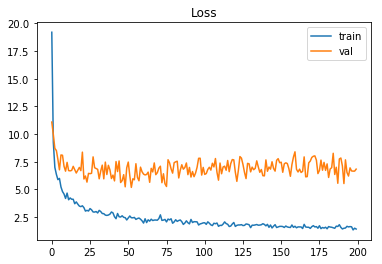

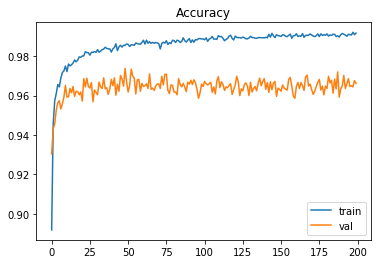

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plt = np.arange(nb_epoch)
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(x_plt, h.history['accuracy'], label='train')
plt.plot(x_plt, h.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.show()